# Simulating Language 19, Greenbergian Universals (lab) (some answers)

This simulation features a replication of
the Culbertson & Smolensky model of learning biases for Greenberg’s Universal 18.

|.        | N-Adj | Adj-N |
|---------|-------|-------|
|**Num-N**|  17%  | 27%   |
|**N-Num**|  52%  | 4%    |

Do the usual stuff to import modules and set up plotting. Note that there are some extra functions here to handle various ways of generating random numbers and deal with probabilities.

In [1]:
import random
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')

from scipy.stats import beta, binom
from math import log, exp
from scipy.misc import logsumexp
from numpy.random import choice, binomial

## Overview

The model uses Bayesian inference to predict the types of grammars learners will infer given (1) a set of counts of [Adj-N, N-Adj, Num-N, N-Num] utterances and (2) their prior expectations in terms of variation and ordering combinations. The first part of code imports what we’ll need to use the binomial and beta distributions, to do logs and exponentials, and to generate random numbers of various kinds.

## The input data

The input consists of counts of [Adj-N, N-Adj, Num-N, N-Num] with 40 total per modifier type. Whether the input is skewed toward pre- or post-nominal modifiers for each phrase type depends on the condition, as shown in the table.


|condition   | training counts|
|------------|---------------|
|1 | [28,12,28,12] |
|2 | [12,28,12,28] |
|3 | [12,28,28,12] |
|4 | [28,12,12,28] |

As in your previous lab, we’ll use a grid of probabilities to describe the space of possible generating grammars. This time, we’ll need to use the grid twice–once for the probability of Adj-N (vs N-Adj), and again for the probability of Num-N (vs. N-Num).

In [2]:
training_data = [[28, 12, 28, 12], [12, 28, 12, 28], [12, 28, 28, 12], [28, 12, 12, 28]]

grid_granularity = 100 
possible_p = []
for i in range(1, grid_granularity):
    possible_p.append(i / (grid_granularity + 0.))

*Check out `training_data`. How would you access just the counts for condition 2? Also take a look at the grid. How is it different from the one you used in the previous lab?*

In [3]:
print(training_data[1])
print(possible_p)

[12, 28, 12, 28]
[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]


## Likelihood

The likelihood here is calculated using the binomial distribution, the same you used to calculated the likelihood of a particular sequence of word 0’s and word 1’s in the previous lab. Only difference is that here we don’t care what order they were heard in, just about the number of Adj-N out of all Adj trials, and the number of Num-N out of all Num trials.

The function below calculates log likelihood of data, (where data are counts representing number of Adj-N out of total Adj instances and number of Num-N out of total Num instances) given point probability of Adj-N, and Num-N.

In [4]:
def U18_likelihood(data, p_AdjN, p_NumN):
    loglikelihood = []
    loglikelihood_AdjN = binom.logpmf(data[0], data[0] + data[1], p_AdjN)
    loglikelihood_NumN = binom.logpmf(data[2], data[2] + data[3], p_NumN)
    loglikelihood = loglikelihood_AdjN + loglikelihood_NumN #summing logs = multiplying non-log
    return loglikelihood   

*Check out U18_likelihood. Notice that it returns log probabilities. Find the line in the function that would allow you to calculate the likelihood of getting 28 Adj-N counts out of a total of 40 when the underlying probability of Adj-N according to the grammar is 0.7 compared to 0.3. Calculate it!*

## Prior

The prior in this model has two parts. One part you know about already: regularization as encoded by the parameters of the beta distribution. In the last lab you used a single parameter, alpha, for a single symmetrical beta distribution. Here we want two separate asymmetrical beta distributions–favoring either probabilities close to one or close to zero, but not both.

The two parameters of the beta distribution are (annoyingly) called alpha and beta. To get the second part of the prior–the part which favors particular combinations of orders (i.e., Adj-N with Num-N) we need to promote or penalize particular parts of the two dimensional grammar space. 

![alt text](http://ling.ed.ac.uk/~simon/simlang/fig2.jpg "grammar space")

We can do this by defining four “components" using different combinations of alpha and beta, with alpha constrained to be higher than beta. The graph below shows beta distributions with (alpha=10, beta=10), (alpha=15, beta=3), (alpah=15, beta=0.1) for Adj-N, and the reverse for Num-N:

![alt text](http://ling.ed.ac.uk/~simon/simlang/fig3.jpg "beta distributions")

Given these four components, we calculate the prior probability of any grammar. This will actually be the sum of its probability given the beta distributions governing p(Adj-N) and p(Num-N) for each component, weighted by the probability of that component. The latter is determined by g. If the probability of a given component (e.g., g[4]) is low, then even grammars very likely to be generated by it will have a low prior probability.

The function below calculates the log prior probability of a given p_AdjN and p_NumN given a set of parameters. This is a sum over the probabilities given by each mixture component. Parameters are: g (set of four mixture weights), a(lpha), b(eta) (Beta shape parameters).

In [5]:
def U18_prior(g, a, b, p_AdjN, p_NumN):
    pattern1_component = [a, b, a, b] # higher prob for Adj-N, Num-N
    pattern2_component = [b, a, b, a] # higher prob for N-Adj, N-Num
    pattern3_component = [b, a, a, b] # higher prob for N-Adj, Num-N
    pattern4_component = [a, b, b, a] # higher prob for Adj-N, N-Num
    components = [pattern1_component, pattern2_component, 
                  pattern3_component, pattern4_component]
    logprior = []
    for i in range(0,4): # loop over all four components
        logprior_i_Adj = beta.logpdf(p_AdjN, components[i][0], components[i][1])
        logprior_i_Num = beta.logpdf(p_NumN, components[i][2], components[i][3])
        logprior_i = logprior_i_Adj + logprior_i_Num
        logprior.append(logprior_i)
    # a+b+... in log space = log(exp(a)+exp(b)+...)
    logprior = log((g[0] * exp(logprior[0])) + 
                   (g[1] * exp(logprior[1])) + 
                   (g[2] * exp(logprior[2])) + 
                   (g[3] * exp(logprior[3])))
    return logprior

*Take a look at the four components in the prior. Can you see why they are defined by those combinations of alpha and beta?*

*Each component - a combination of two beta distributions - can in principle generate any grammar, that is any pair p(Adj-N), p(Num-N). Which component assigns the highest probability to the pair (0.8,0.8)? How about (0.4,0.9)?*

### The optimal prior parameters

The parameters of the prior are alpha, beta, g. The first two (called a, and b in the code) encode the regularization bias. The higher a is relative to b, the more regularization. The third, g is a set of weights for the four components, summing to 1. We searched through these parameters to find the ones that fit our experimental data (shown in the plot below) best.

![alt text](http://ling.ed.ac.uk/~simon/simlang/fig4.jpg "experimental data")

The best fit parameters were:

In [6]:
#                  g                           alpha, beta
fit_parameters = [[0.6293, 0.3706, 0.0001, 0], 16.5,  0.001]

## Posterior

The posterior distribution over grammars can now be calculated using the likelihood and the prior with the fit parameters. This function calculates the log posterior probability of a set of counts for all possible p_AdjN, p_NumN combinations, given prior parameters g, a(lpha), b(eta).

In [7]:
def U18_posterior(g, a, b, data):
    posterior = [] 
    for p_a in range(len(possible_p)):
        for p_n in range(len(possible_p)):
            lik_i = U18_likelihood(data, possible_p[p_a], possible_p[p_n])
            prior_i = U18_prior(g, a, b, possible_p[p_a], possible_p[p_n]) 
            posterior.append(lik_i + prior_i)  
    return posterior

*Given the fit parameters, will the model predict a weak or strong regularization bias? Will a set of counts generated from a grammar like (0.8,0.2) have a high, medium, low posterior probability?*

## Plot the results

The model can now be used to generate predicted learning outcomes; given some input data, and the prior parameters, we can generate sampled grammars and plot them in the two-dimensional grammar space we’ve be using. The figure belows shows this as reported in the original Culbertson & Smolensky paper. 

![alt text](http://ling.ed.ac.uk/~simon/simlang/fig5.jpg "culbertson & smolensky results")

You can use the `U18_roulette_wheel` function to reproduce this. This function is similar to those you’ve previously used to sample probabilities. The difference is that this function samples pairs of p(Adj-N), p(Num-N) probabilities, and it lets you specify how many such samples you want. You’ll notice there’s also a normalization function `normalize_log_distribution` which takes log probabilities output by the posterior and makes them a proper (non-log) probability distribution for plotting.

In [8]:
def normalize_log_distribution(distribution):
    exp_dist = []
    for logp in distribution:
        exp_dist.append(exp(logp))
    norm_dist = []
    for p in exp_dist:
        norm_dist.append(p / sum(exp_dist))
    return norm_dist


def U18_roulette_wheel(g, a, b, data, num_samps):
    post = U18_posterior(g, a, b, data) # calculate posterior given training data and prior parameters
    post = normalize_log_distribution(post)
    # make a grid of all possible p_AdjN, p_NumN combinations at the granularity specified
    grid = []
    for p_a in range(len(possible_p)):
        for p_n in range(len(possible_p)):
            grid.append([possible_p[p_a], possible_p[p_n]])
    # samples some grammars!
    grammars = []
    for i in range(num_samps):
        r = choice(a=range(len(grid)), p=post)   # choose an index from the grid according to it's posterior probability  
        grammars.append(grid[r])
    return grammars

Now we have a function to plot the results as a scatter plot.

In [9]:
def plot_grammars(g_1, g_2, g_3, g_4):
    
    plt.figure(figsize=(6, 6))
    for g in g_1:
        plt.scatter([g[0]], [g[1]], color='red', alpha=0.5)

    for g in g_2:
        plt.scatter([g[0]], [g[1]], color='blue', alpha=0.5)

    for g in g_3:
        plt.scatter([g[0]], [g[1]], color='orange', alpha=0.5)

    for g in g_4:
        plt.scatter([g[0]], [g[1]], color='purple', alpha=0.5)

    plt.xlabel("P(Adj-N)")
    plt.ylabel("P(Num-N)")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid()

## Questions

1. Generate samples `g_1, g_2, g_3, g_4` using function calls like:
```python
g_1 = U18_roulette_wheel(fit_parameters[0], fit_parameters[1], fit_parameters[2], training_data[0], 100)
```
Then call the plotting function to plot them. Does your plot look like figure above from the paper? (N.B. This might take a while to run.)

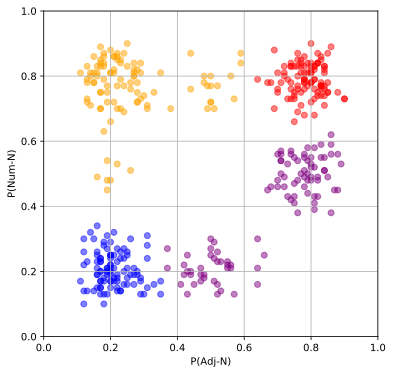

In [10]:
g_1 =  U18_roulette_wheel(fit_parameters[0], fit_parameters[1], fit_parameters[2], training_data[0], 100)
g_2 =  U18_roulette_wheel(fit_parameters[0], fit_parameters[1], fit_parameters[2], training_data[1], 100)
g_3 =  U18_roulette_wheel(fit_parameters[0], fit_parameters[1], fit_parameters[2], training_data[2], 100)
g_4 =  U18_roulette_wheel(fit_parameters[0], fit_parameters[1], fit_parameters[2], training_data[3], 100)
plot_grammars(g_1, g_2, g_3, g_4)

2. What does it mean that the highest value of g is for component 1? Why do you think that might be the highest given the population of learners tested in the experiment? Come up with a new set of g values that you think would more accurately reflect the typology (e.g., in table at the start of the notebook) and redo the samples and plot. Did it turn out as you expected?

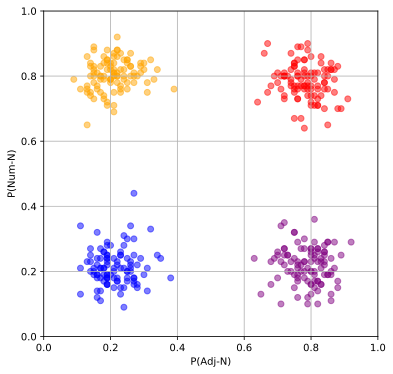

In [12]:
g_1 = U18_roulette_wheel([.27, .52, .17, .04], fit_parameters[1], fit_parameters[2], training_data[0], 100)
g_2 = U18_roulette_wheel([.27, .52, .17, .04], fit_parameters[1], fit_parameters[2], training_data[1], 100)
g_3 = U18_roulette_wheel([.27, .52, .17, .04], fit_parameters[1], fit_parameters[2], training_data[2], 100)
g_4 = U18_roulette_wheel([.27, .52, .17, .04], fit_parameters[1], fit_parameters[2], training_data[3], 100)
plot_grammars(g_1, g_2, g_3, g_4)

3. What do you think would happen if the regularization bias were not as strong? Change the a,b parameters and see if you were right.

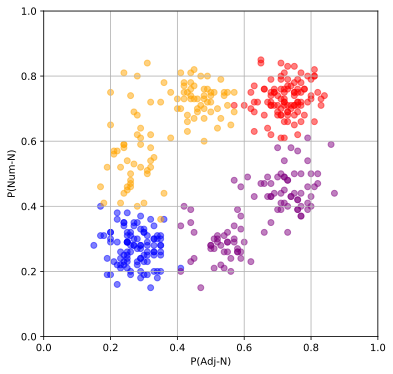

In [15]:
g_1 =  U18_roulette_wheel(fit_parameters[0], fit_parameters[1], 5, training_data[0], 100)
g_2 =  U18_roulette_wheel(fit_parameters[0], fit_parameters[1], 5, training_data[1], 100)
g_3 =  U18_roulette_wheel(fit_parameters[0], fit_parameters[1], 5, training_data[2], 100)
g_4 =  U18_roulette_wheel(fit_parameters[0], fit_parameters[1], 5, training_data[3], 100)
plot_grammars(g_1, g_2, g_3, g_4)

## Taking it further: iterating the model (optional)

The remaining functions in this notebook are for iterating the model - taking the original training data, generating posterior probability distributions for all four conditions, sampling some grammars from each posterior and counting the number of each pattern type that results. Then, generating some new training data from one of the sampled grammars from each condition to pass on to the next generation. And so on.

The first function classifies a given grammar as one of the four patterns. So if a learner acquires (0.7,0.8) that would be classified as a pattern 1 grammar. We’ll need this to track the counts of each pattern type over generations.

In [16]:
def U18_classify(p_AdjN, p_NumN):
    if p_AdjN > 0.5 and p_NumN > 0.5: return 1
    if p_AdjN < 0.5 and p_NumN < 0.5: return 2 
    if p_AdjN < 0.5 and p_NumN > 0.5: return 3
    if p_AdjN > 0.5 and p_NumN < 0.5: return 4
    else: return 0

The second function generates training data given a grammar by taking sampled counts from a binomial distribution. We’ll need this to create new training data to pass on to the next generation of learners. 

In [17]:
def U18_produce(p_AdjN, p_NumN):
    AdjN = binomial(n=40, p=p_AdjN) # number of Adj-N out of n trials with p=p_AdjN
    NumN = binomial(n=40, p=p_NumN) # number of Num-N out of n trials with p=p_NumN
    return [AdjN, 40-AdjN, NumN, 40-NumN]

And finally, a pretty horrendous looking function does the iterating. This iterates from starting data consisting of counts of Adj-N, Num-N. It returns number of each pattern type left out of num_samps * 4 in each generation. The steps it follows are: 
1. get samples from each condition given starting_data
2. pick random grammar from each set of samples and use to generate new starting_data for that condition
3. count the number of each patterns resulting from those samples
4. REPEAT

This function returns a list of lists. Each list in there tracks the counts for one of the four patterns over generations. If you ran 3 generations there’d be three numbers in each list representing how many of each pattern resulted from learning in that generation.

There are four loops. The outermost loop goes through the generations (as many as the user specifies). The second loop goes through each condition for the current generation, samples some grammars from the posterior for that condition and picks one of them to generate new training data from, to pass on to the next generation. The third loop classifies all the sampled patterns. The fourth loop puts the counts of each pattern for the current generation into the value of the function to be output.

In [18]:
def U18_iterate(starting_data, g, a, b, generations, num_samps):
    
    pattern_tracer=[[], [], [], []] # value of the function, each sublist 
                                    # tracks count of each pattern type over generations   
    for gen in range(generations):
        patterns_g = [] # accumulator for pattern types in each sample for current generation
        new_data=[[], [], [], []] # to be used as starting_data in the subsequent generation
        
        # for each condition, get sample of grammars, generate new training data, 
        # count patterns...
        for i in range(4):
            print("sampling for condition " + str(i+1) + "...")
            samps_i = U18_roulette_wheel(g, a, b, starting_data[i], num_samps) # get sample of grammars
            r = random.randint(0, num_samps - 1)# pick a random index from samps
            training_g = samps_i[r] # get the grammar at index r 
            print("learner has acquired: " + str(training_g))
            new_data[i] = U18_produce(training_g[0], training_g[1]) # use grammar to generate new data
            print("passing on:" + str(new_data[i]) + " to next generation...")
            # now for each grammar in the sample, classify it and add pattern to the accumulator
            for s in range(len(samps_i)):
                patterns_g.append(U18_classify(samps_i[s][0], samps_i[s][1]))
        
        # go through pattern accumulator and count each type for the current generation
        for i in range(4): 
            pattern_tracer[i].append(patterns_g.count(i + 1)) # add the set of patterns to list
        print("Frequency of patterns for this generation: " + str(pattern_tracer))
            
        starting_data = new_data # make the new training data the starting data
    
    return pattern_tracer

To do some iterating, call the function with the following arguments. It will take awhile, and you’ll notice that the function has some print statements so you know what it’s up to while you’re waiting.

```python
counts = U18_iterate(training_data, fit_parameters[0], fit_parameters[1], fit_parameters[2], 3, 100)
```

In [19]:
counts = U18_iterate(training_data, fit_parameters[0], fit_parameters[1], fit_parameters[2], 3, 100)

sampling for condition 1...
learner has acquired: [0.76, 0.86]
passing on:[34, 6, 34, 6] to next generation...
sampling for condition 2...
learner has acquired: [0.19, 0.16]
passing on:[6, 34, 8, 32] to next generation...
sampling for condition 3...
learner has acquired: [0.53, 0.76]
passing on:[16, 24, 33, 7] to next generation...
sampling for condition 4...
learner has acquired: [0.71, 0.57]
passing on:[29, 11, 21, 19] to next generation...
Frequency of patterns for this generation: [[145], [119], [89], [41]]
sampling for condition 1...
learner has acquired: [0.9, 0.96]
passing on:[36, 4, 38, 2] to next generation...
sampling for condition 2...
learner has acquired: [0.1, 0.17]
passing on:[3, 37, 7, 33] to next generation...
sampling for condition 3...
learner has acquired: [0.65, 0.93]
passing on:[27, 13, 37, 3] to next generation...
sampling for condition 4...
learner has acquired: [0.82, 0.74]
passing on:[37, 3, 31, 9] to next generation...
Frequency of patterns for this generatio

In order to plot the outcome of the iterated learning simulation, you can use the following code:

```python
plt.plot(counts[0], color='red', label='pattern 1')
plt.plot(counts[1], color='blue', label='pattern 2')
plt.plot(counts[2], color='orange', label='pattern 3')
plt.plot(counts[3], color='purple', label='pattern 4')
plt.xlabel('generations')
plt.ylabel('count')
plt.legend()
```

This will show you which patterns survive, and which die out over generations. Do you think this is a realistic result? Why or why not?

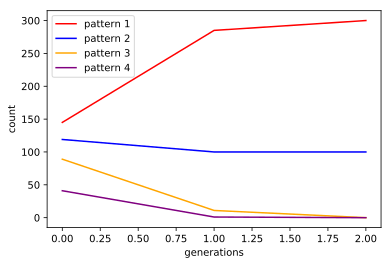

In [20]:
plt.plot(counts[0], color='red', label='pattern 1')
plt.plot(counts[1], color='blue', label='pattern 2')
plt.plot(counts[2], color='orange', label='pattern 3')
plt.plot(counts[3], color='purple', label='pattern 4')
plt.xlabel('generations')
plt.ylabel('count')
plt.legend()